In [1]:
import pandas as pd
def preprocess_data(continuous_after: pd.DataFrame) -> pd.DataFrame:
    unknown_employment_index = continuous_after[ (continuous_after['employmentStatus_Full_Time'] == 0) & (continuous_after['employmentStatus_Part_Time'] == 0) & (continuous_after['employmentStatus_Unemployed'] == 0)].index
    unknown_employment_age = continuous_after[ (continuous_after['employmentStatus_Part_Time'] == 0) & (continuous_after['employmentStatus_Unemployed'] == 0) & (continuous_after['employmentStatus_Full_Time'] == 0) ]['age']
    unemployment_index = continuous_after[ continuous_after['employmentStatus_Unemployed'] == 1].index
    unknown_employment_index

    type1_index = list(unemployment_index) + list(unknown_employment_index)
    type2_index = list(continuous_after[ continuous_after['employmentStatus_Full_Time'] == 1].index) + list(continuous_after[ continuous_after['employmentStatus_Part_Time'] == 1].index)
    new_row = [0] * continuous_after.shape[0]
    for index in type1_index:
        new_row[index] = 1

    continuous_after['Employed'] = new_row
    continuous_after.drop(['employmentStatus_Part_Time', 'employmentStatus_Full_Time'], axis =1, inplace = True )

    new_row = [0] * continuous_after.shape[0]
    for index in type2_index:
        new_row[index] = 1
    
    continuous_after['Unemployed'] = new_row
    continuous_after.drop(['employmentStatus_Unemployed'], axis =1, inplace = True )
    continuous_after.drop(['Unemployed','ocp_wr_low_los', 'ocp_jl_low_los', 'ocp_hd_low_los','licenseStatus_Not_Suspended','licenseStatus_Suspended'], axis=1, inplace=True) 

    #Cost multiplication
    continuous_after['weighted_jl_total'] = continuous_after['c_occu_jail']*continuous_after['ocp_jl_total']
    continuous_after['weighted_wr_total'] = continuous_after['c_occu_wr']*continuous_after['ocp_wr_total']
    continuous_after['weighted_hd_total'] = continuous_after['c_occu_hd']*continuous_after['ocp_hd_total']
    continuous_after.drop(['c_occu_jail', 'c_occu_wr', 'c_occu_hd', 'ocp_jl_total', 'ocp_wr_total', 'ocp_hd_total'], axis = 1, inplace=True)

    # one hot encoding  -> the target is "placement", so we don't need to encode this column, also bcz RandomForest can handle categorical target data
    # work release = 0 | home detention = 1 | jail = 2
    for ind, item in continuous_after.iterrows():
        if item['placement'] == 'work release':
            continuous_after['placement'].iat[ind] = '0'
        elif item['placement'] == 'home detention':
            continuous_after['placement'].iat[ind] = '1'
        elif item['placement'] == 'jail':
            continuous_after['placement'].iat[ind] = '2'

    #object to int
    continuous_after['placement'] = pd.to_numeric(continuous_after['placement'])

    # drop imbalanced data #JUNE 5th: TUNR OFF THESE DROPPINGS
    #continuous_after.drop(['race_Other', 'registeredSexOffender_TRUE', 'violentOffender_TRUE', 'gangMember_x_TRUE', 'homeless_TRUE'], axis = 1, inplace = True)

    return continuous_after 

from sklearn.model_selection import train_test_split
def split_data(my_csv: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    y = my_csv["placement"]
    X = my_csv.drop(["placement"], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split( X, y, train_size = 0.7, random_state = 50) 

    return X_train, X_test, y_train, y_test

C:\Users\voqua\AppData\Local\Temp\ipykernel_34920\3173346450.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
import pandas as pd
df = pd.read_csv("Model_framework\outputs\datasets\demographics_to_placement_simulation_WR_no_cap_continuous_2.csv")

df2 = preprocess_data(df)

X_train, X_test, y_train, y_test = split_data(df2)

<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
C:\Users\voqua\AppData\Local\Temp\ipykernel_34920\3822868145.py:2: SyntaxWarning: invalid escape sequence '\M'
  df = pd.read_csv("Generative-AI-and-LLM-in-Healthcare-Operations\Model_framework\outputs\datasets\demographics_to_placement_simulation_WR_no_cap_continuous_2.csv")


In [43]:
X_train.shape

(71591, 18)

In [3]:
from sklearn.ensemble import RandomForestClassifier

In [4]:
rf = RandomForestClassifier(max_depth=13, n_estimators=150,
                            min_samples_leaf=4, max_features='sqrt', random_state = 50)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=13, min_samples_leaf=4, n_estimators=150,
                       random_state=50)

In [ ]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_test)

In [ ]:
import pickle
with open("Model_framework/outputs/shap_values/recidivism_shap_placement.pkl", "rb") as f:
    shap_values_temp = pickle.load(f)

c:\Python\Python312\Lib\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import shap

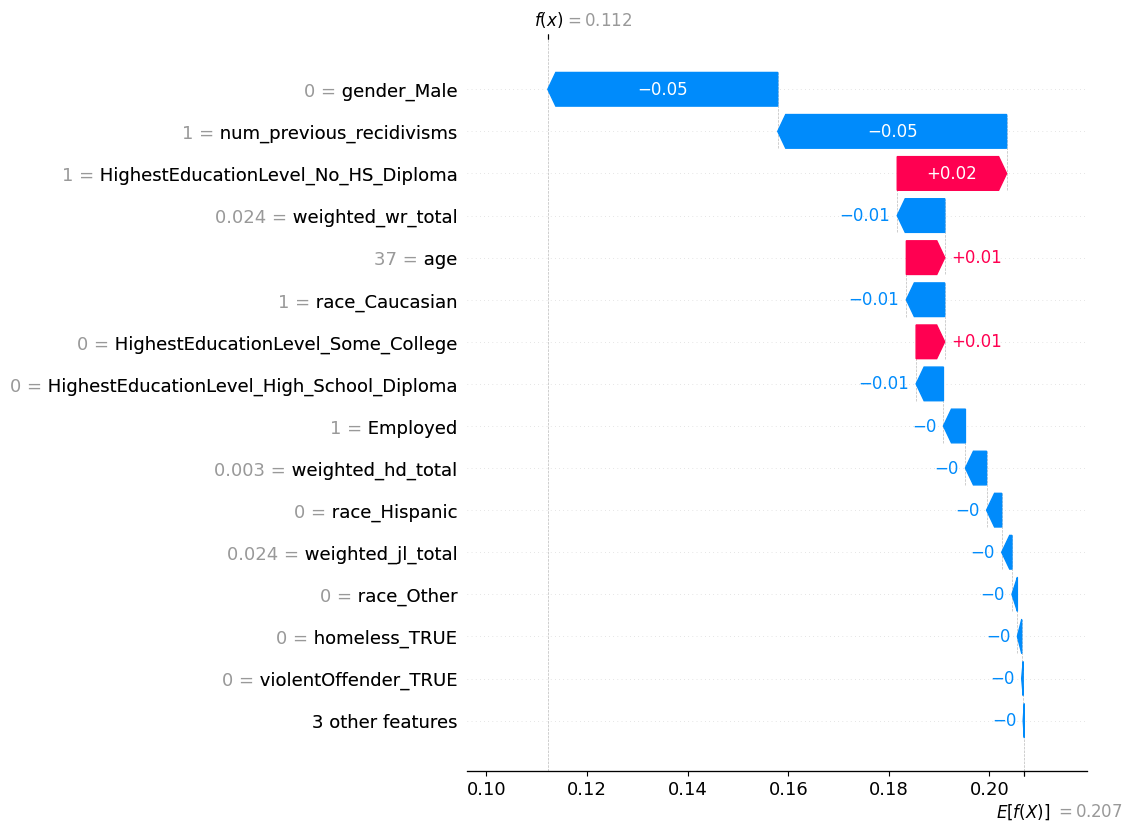

In [39]:
shap.plots.waterfall(shap_values_temp[0,:,1], max_display=16) #5, 12 | (high) 13, 0

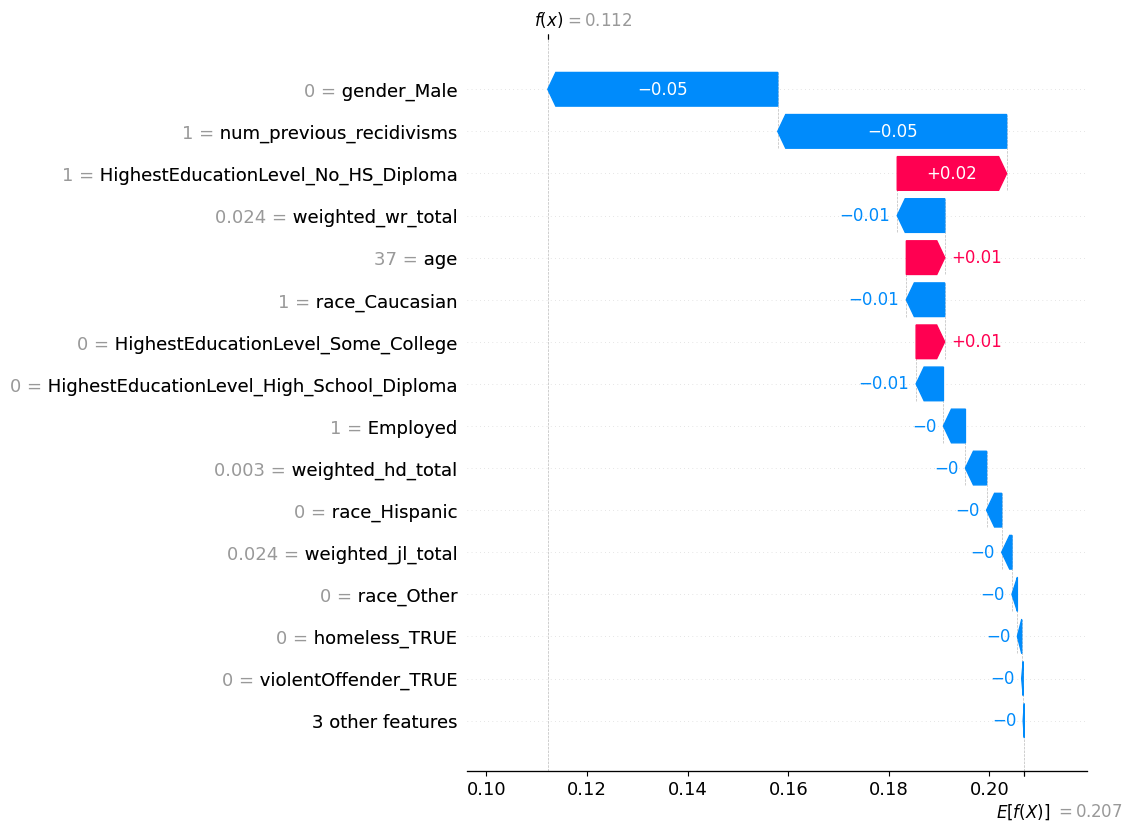

In [ ]:
shap.plots.waterfall(shap_values_temp[0,:,1], max_display=16) #0

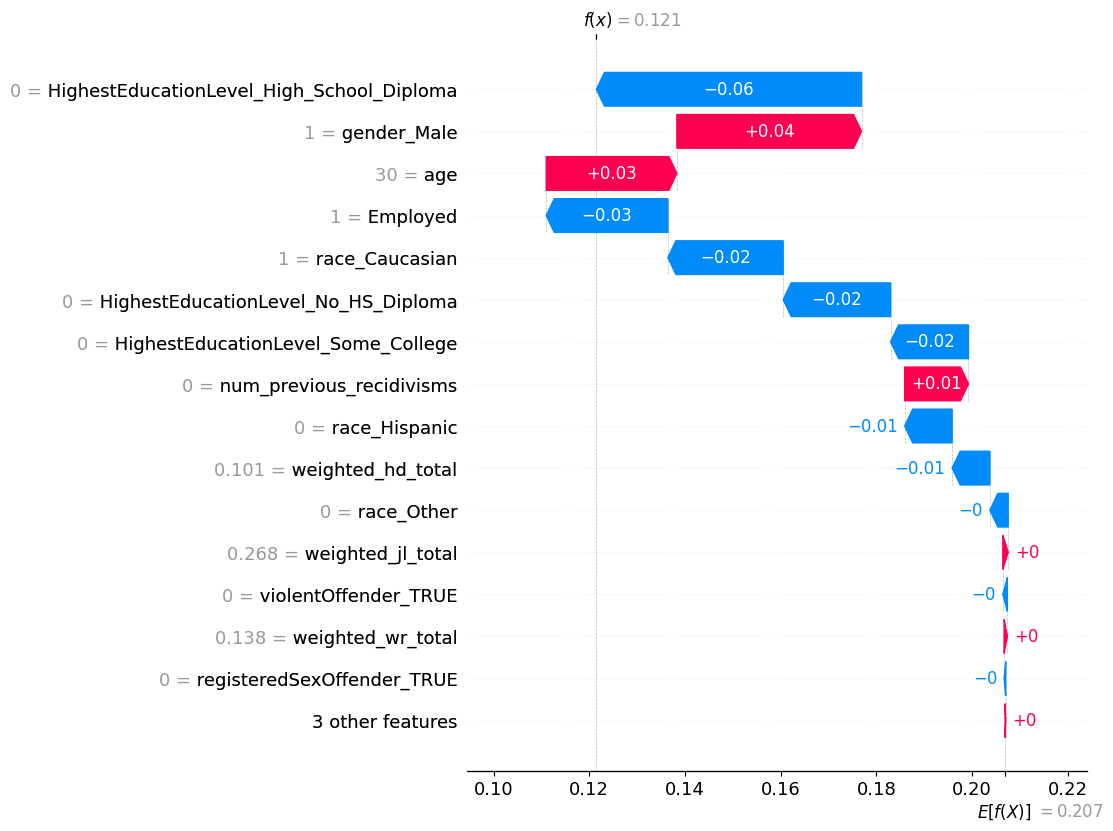

In [34]:
shap.plots.waterfall(shap_values_temp[5,:,1], max_display=16) 